In [1]:
import sys

import helper_functions

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.7 MB/s 
     |████████████████████████████████| 182 kB 63.9 MB/s 


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline
from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [5]:
df = pd.read_csv('Corrys.csv', index_col = [0])

In [ ]:
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

# Sentiment Analysis

In [6]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [7]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero-Shot Classifier

In [8]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
# insert the labels you identified from above section
type = ['cost', 'efficient', 'effective', 'ease of use']

In [10]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


In [11]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)

In [12]:
df = df.reset_index(drop=True)
df['other_m'] = 0
for row in range(len(df)):
    if df.at[row, 'max'] < 0.7:
        df.at[row, 'other_m'] = 1

In [13]:
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)
df['cost_m'] = imputation(df['cost_m'])
df['efficient_m'] = imputation(df['efficient_m'])
df['effective_m'] = imputation(df['effective_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

In [14]:
df['cost_m'] = df['cost_m'].replace(1, 'cost')
df['cost_m'] = df['cost_m'].replace(0, '')
df['efficient_m'] = df['efficient_m'].replace(1, 'efficient')
df['efficient_m'] = df['efficient_m'].replace(0, '')
df['effective_m'] = df['effective_m'].replace(1, 'effective')
df['effective_m'] = df['effective_m'].replace(0, '')
df['ease of use_m'] = df['ease of use_m'].replace(1, 'ease of use')
df['ease of use_m'] = df['ease of use_m'].replace(0, '')
df['other_m'] = df['other_m'].replace(1, 'other')
df['other_m'] = df['other_m'].replace(0, '')

In [25]:
align_list=[]
for i in range(len(df)):
    interim_list = []
    interim_list = df.iloc[i][26],df.iloc[i][27],df.iloc[i][28],df.iloc[i][29],df.iloc[i][31]
    align_list.append(interim_list)
df['align_type']=align_list

In [26]:
df.to_csv('prepared_df.csv')

# Insights

In [4]:
df = pd.read_csv('prepared_df_Corrys.csv')

## Heatmap

In [5]:
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'\', \'\')', 'cost')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'\', \'\')', 'efficient')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'\', \'\')', 'effective')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'ease of use\', \'\')', 'ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'\', \'other\')', 'other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'\', \'\', \'\')', 'cost, efficient')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'effective\', \'\', \'\')', 'cost, effective')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'ease of use\', \'\')', 'cost, ease of use')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'\', \'other\')', 'cost, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'\', \'\')', 'efficient, effective')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'ease of use\', \'\')', 'efficient, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'\', \'other\')', 'efficient, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'ease of use\', \'\')', 'effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'\', \'other\')', 'effective, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'ease of use\', \'other\')', 'ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'\', \'\')', 'efficient, effective')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'\', \'\')', 'cost, efficient, effective')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'effective\', \'ease of use\', \'\')', 'cost, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'ease of use\', \'other\')', 'cost, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'ease of use\', \'\')', 'efficient, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'ease of use\', \'other\')', 'efficient, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'ease of use\', \'other\')', 'effective, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'ease of use\', \'\')', 'cost, efficient, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'ease of use\', \'other\')', 'efficient, effective, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'ease of use\', \'other\')', 'cost, efficient, effective, ease of use, other')
df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'\', \'ease of use\', \'\')', 'cost, efficient, ease of use')

In [6]:
df2=df.groupby(['align_type', 'sentiment_m'])['align_type'].count().rename("count").groupby(level = 0).transform(lambda x: x/400*100).reset_index(name = 'count %')

<Figure size 864x360 with 0 Axes>

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, -248.375, '')]

[Text(79.5, 0.5, ''), Text(0.5, -248.375, '')]

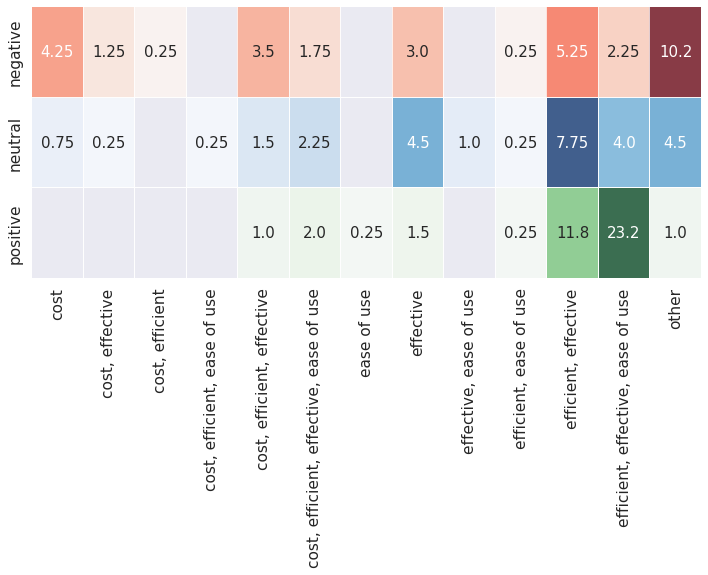

In [10]:
table = pd.pivot_table(df2, values='count %', index=['sentiment_m'], columns=['align_type'])

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['negative'] = float('nan')
data1.loc['neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['negative'] = float('nan')
data2.loc['positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['positive'] = float('nan')
data3.loc['neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [11]:
df3=df.groupby(['align_type', 'sentiment_m'])['align_type'].count().rename("count").groupby(level = 0).transform(lambda x: x/x.sum()*100).reset_index(name = 'count %')

<Figure size 864x360 with 0 Axes>

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, -248.375, '')]

[Text(79.5, 0.5, ''), Text(0.5, -248.375, '')]

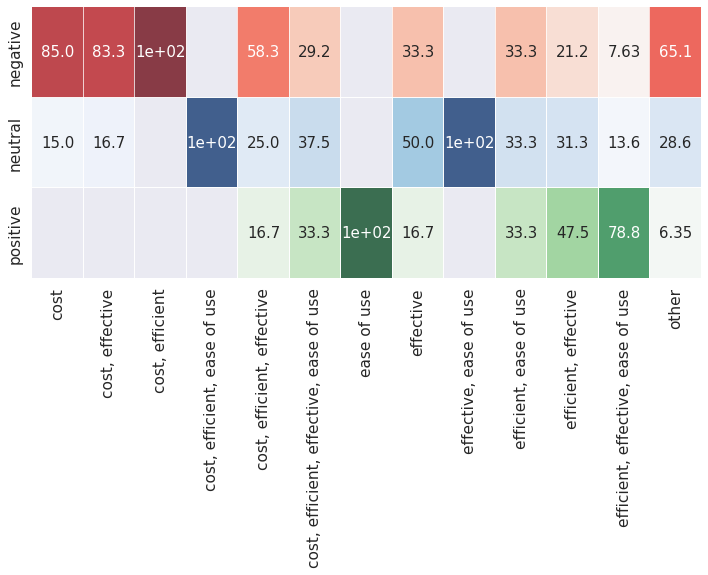

In [12]:
table = pd.pivot_table(df3, values='count %', index=['sentiment_m'], columns=['align_type'])

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['negative'] = float('nan')
data1.loc['neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['negative'] = float('nan')
data2.loc['positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['positive'] = float('nan')
data3.loc['neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

## Treemap

In [13]:
# Treemap
from collections import defaultdict
import plotly
import plotly.express as px

data =  df
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+percent parent'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

In [14]:
# Treemap
from collections import defaultdict
import plotly
import plotly.express as px

data =  df
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+percent root'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

# For 5 star rating reviews

In [38]:
df_5 = df[df['rating'] == 5]

Text(0.5, 1.0, 'Top 10 Products with 5 Ratings')

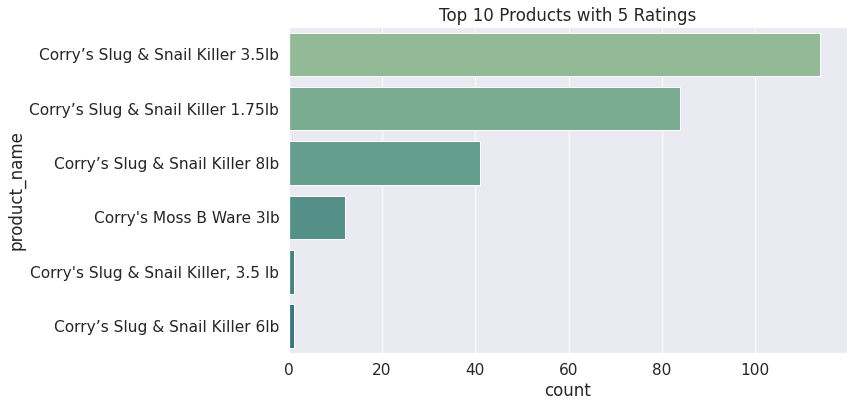

In [39]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 5 Ratings');
sns.countplot(y = 'product_name', data = df_5, order = df_5['product_name'].value_counts()[0:10].index, palette=sns.color_palette("crest", n_colors=10))
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

# N-gram

In [40]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [41]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_5["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/usr/local/lib/python3.8/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# For 1 Star Rated Reviews

In [42]:
df_1 = df[df['rating'] == 1]

Text(0.5, 1.0, 'Top 10 Products with 1 Ratings')

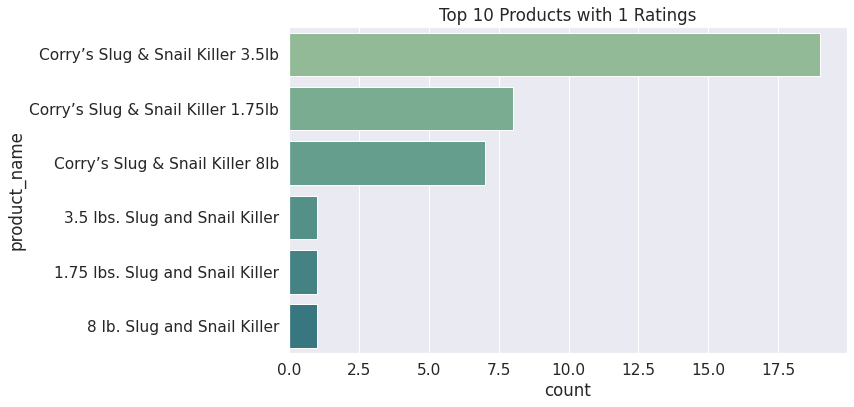

In [43]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 1 Ratings');
sns.countplot(y = 'product_name', data = df_1, order = df_1['product_name'].value_counts()[0:10].index, palette=sns.color_palette("crest", n_colors=10))
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

In [44]:
## Get the bar chart from 1 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_1["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/usr/local/lib/python3.8/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [45]:
df.to_csv('evaluation_PenningtonFertilizer.csv')